Discrimination is the act of someone being prejudice towards another. Forms of discrimination include nationalist, race, gender, religions, etc. 

As in modern world, non-discrimination has been stated on varies websites. On the bottom of each page of Lending Club, “Equal Housing Lender” logo appears, which means that "the bank makes loans without regard to race, color, religion, national origin, sex, handicap, or familial status." However, this logo doesn’t mean the web is 100% fair. In this context, we want to do more analysis  to test discrimination.

However, due to the limitation of the data set, we can only focus analysis on state level. Our final goal is to find the relationship between loan return rate and loan accepting rate for each state.

In [1]:
import calendar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.plotly as py

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score

%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

## Discrimination Analysis 

To investigate whether there exists discrimination in LandingClub, we simplify our question as: whether applicants from a certain state were less likely to receive a loan.    
One way we think about this question is that for a given state if the rejection rate is higher than the proportion of loans of that state among total loans, then that state is likely to be underprivileged.     
The other way is that there should be a postive associate between the acceptance rate and the probability of fully paid. So we want to use data of 50 states to fit a linear regression model, the states under the trend line are likely to be underprivileged while those above the trend line should be considered as being privileged.

### Data Summary

In [2]:
acc_data = pd.read_csv('cdf_acc2016.csv')
acc_data.head()

,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,35000,35000,60,21.18,950.42,E,10+,MORTGAGE,195000.0,1,Mar-2016,1,debt_consolidation,871xx,NM,15.56,0,Aug-2004,0,9,0,32223,0.934,28,w,0.0,0.0,47748.356466,47748.36,35000.0,12748.36,Mar-2018,26612.62,Jul-2018,Individual,0,0,644712.0,34500,12,71635,878,91.2,0,0,122,95,7,7,4,15,1,1,4,1,2,17,4,7,4,9,0,0,0,4,88.5,100.0,0,0,671522,166084,10000,138709,N,Cash,N
1,16000,16000,36,5.32,481.84,A,8,RENT,105000.0,0,Mar-2016,1,debt_consolidation,206xx,MD,15.02,1,Nov-2000,0,9,0,6219,0.279,21,w,0.0,0.0,16098.340000,16098.34,16000.0,98.34,May-2016,16107.80,Nov-2016,Individual,0,0,23525.0,22300,3,3361,13632,29.7,0,0,124,184,22,8,0,52,0,2,3,2,5,7,6,14,3,9,0,0,0,2,95.2,0.0,0,0,47543,23525,19400,25243,N,Cash,N
2,9000,9000,36,5.32,271.04,A,10+,MORTGAGE,90000.0,0,Mar-2016,1,home_improvement,581xx,ND,17.97,0,Dec-1989,1,20,0,19386,0.239,42,w,0.0,0.0,9361.741129,9361.74,9000.0,361.74,Feb-2017,6927.70,Feb-2017,Individual,0,0,151359.0,81100,6,7966,48684,28.3,0,0,180,315,3,3,3,3,0,3,5,10,16,12,16,27,5,20,0,0,0,5,100.0,10.0,0,0,288144,61072,67900,54244,N,Cash,N
3,13550,13550,36,10.75,442.01,B,2,MORTGAGE,79000.0,1,Mar-2016,1,credit_card,743xx,OK,19.22,0,Apr-2000,0,9,0,7787,0.666,23,w,0.0,0.0,15537.174857,15537.17,13550.0,1987.17,Feb-2018,6261.07,Sep-2018,Individual,0,2552,135472.0,11700,3,15052,1966,77.9,0,0,138,114,24,13,2,24,1,4,5,4,5,15,5,6,5,9,0,0,0,0,95.7,75.0,0,0,163583,38420,8900,47151,N,Cash,N
4,10000,10000,36,6.49,306.45,A,4,MORTGAGE,70000.0,1,Mar-2016,1,debt_consolidation,478xx,IN,13.66,0,May-1999,0,5,0,24472,0.665,19,w,0.0,0.0,10924.386145,10924.39,10000.0,924.39,May-2018,3576.80,Sep-2018,Individual,0,0,110357.0,36800,1,22071,1921,91.8,0,0,159,202,40,20,2,71,0,2,3,2,7,7,4,10,3,5,0,0,0,0,100.0,100.0,0,0,137157,24472,23300,0,N,Cash,N


In [3]:
# Calculating proportion of fully paid
def success_rate(df):
    succ_rate = list()
    succ_rate.append(len(df[df['loan_status']==1])/len(df))
    return succ_rate

succ_rate_df = acc_data.groupby('addr_state').apply(success_rate)
succ_rate = pd.DataFrame({'State': succ_rate_df.index, 'Success Rate': succ_rate_df.values})
for i in range(len(succ_rate)):
    succ_rate['Success Rate'][i] = succ_rate['Success Rate'][i][0]

In [4]:
df = pd.read_csv('if_loan_is_rejected.csv')
df = df.drop(df[df['State'] == 'IA'].index)
rej = df[df['ifrej']== 1]
acp = df[df['ifrej']== 0]

In [5]:
acc_count = acp['State'].value_counts()
acc_count = pd.DataFrame({'State': acc_count.index, 'Accept Count': acc_count.values})
rej_count = rej['State'].value_counts()
rej_count = pd.DataFrame({'State': rej_count.index, 'Reject Count': rej_count.values})

In [8]:
model = pd.read_csv('cdf_discrimination.csv')
model_roi = pd.read_csv('roi_discrimination.csv')
model_iroi = pd.read_csv('iroi_discrimination.csv')
model.head()

,Unnamed: 0,purpose,emp_length,num_tl_120dpd_2m,acc_now_delinq,annual_inc,revol_bal,avg_cur_bal,mo_sin_old_il_acct,mort_acc,pct_tl_nvr_dlq,addr_state,funded_amnt,total_pymnt,loan_status,Random_Forest,Neural_Network
0,0,debt_consolidation,10+,0,0,195000.0,32223,71635,122,4,88.5,NM,35000,47748.356466,1,0,0
1,1,debt_consolidation,8,0,0,105000.0,6219,3361,124,0,95.2,MD,16000,16098.340000,1,1,1
2,2,home_improvement,10+,0,0,90000.0,19386,7966,180,3,100.0,ND,9000,9361.741129,1,1,1
3,3,credit_card,2,0,0,79000.0,7787,15052,138,2,95.7,OK,13550,15537.174857,1,0,0
4,4,debt_consolidation,4,0,0,70000.0,24472,22071,159,2,100.0,IN,10000,10924.386145,1,1,1


In [11]:
rf_rej = model[model['Random_Forest']== 0][['addr_state', 'Random_Forest']]
rf_acp = model[model['Random_Forest']== 1][['addr_state', 'Random_Forest']]
nn_rej = model[model['Neural_Network']== 0][['addr_state', 'Neural_Network']]
nn_acp = model[model['Neural_Network']== 1][['addr_state', 'Neural_Network']]
roi_rf_rej = model_roi[model_roi['Random_Forest']== 0][['addr_state', 'Random_Forest']]
roi_rf_acp = model_roi[model_roi['Random_Forest']== 1][['addr_state', 'Random_Forest']]
roi_nn_rej = model_roi[model_roi['Neural_Network']== 0][['addr_state', 'Neural_Network']]
roi_nn_acp = model_roi[model_roi['Neural_Network']== 1][['addr_state', 'Neural_Network']]
iroi_rf_rej = model_iroi[model_iroi['Random_Forest']== 0][['addr_state', 'Random_Forest']]
iroi_rf_acp = model_iroi[model_iroi['Random_Forest']== 1][['addr_state', 'Random_Forest']]
iroi_nn_rej = model_iroi[model_iroi['Neural_Network']== 0][['addr_state', 'Neural_Network']]
iroi_nn_acp = model_iroi[model_iroi['Neural_Network']== 1][['addr_state', 'Neural_Network']]

acc_rf_counts = rf_acp['addr_state'].value_counts()
acc_rf_counts_df = pd.DataFrame({'State': acc_rf_counts.index, 'RF Accept Counts': acc_rf_counts.values})
acc_nn_counts = nn_acp['addr_state'].value_counts()
acc_nn_counts_df = pd.DataFrame({'State': acc_nn_counts.index, 'NN Accept Counts': acc_nn_counts.values})
roi_acc_rf_counts = roi_rf_acp['addr_state'].value_counts()
roi_acc_rf_counts_df = pd.DataFrame({'State': roi_acc_rf_counts.index, 'ROI RF Accept Counts': roi_acc_rf_counts.values})
roi_acc_nn_counts = roi_nn_acp['addr_state'].value_counts()
roi_acc_nn_counts_df = pd.DataFrame({'State': roi_acc_nn_counts.index, 'ROI NN Accept Counts': roi_acc_nn_counts.values})
iroi_acc_rf_counts = iroi_rf_acp['addr_state'].value_counts()
iroi_acc_rf_counts_df = pd.DataFrame({'State': iroi_acc_rf_counts.index, 'IROI RF Accept Counts': iroi_acc_rf_counts.values})
iroi_acc_nn_counts = iroi_nn_acp['addr_state'].value_counts()
iroi_acc_nn_counts_df = pd.DataFrame({'State': iroi_acc_nn_counts.index, 'IROI NN Accept Counts': iroi_acc_nn_counts.values})

In [12]:
# Summarise successfully-paid rate, accept rate, accept count and reject count
state_rate = pd.merge(succ_rate, acc_count, how='left', on=['State'])
state_rate = pd.merge(state_rate, rej_count, how='left', on=['State'])
state_rate = pd.merge(state_rate, acc_rf_counts_df, how='left', on=['State'])
state_rate = pd.merge(state_rate, acc_nn_counts_df, how='left', on=['State'])
state_rate = pd.merge(state_rate, roi_acc_rf_counts_df, how='left', on=['State'])
state_rate = pd.merge(state_rate, roi_acc_nn_counts_df, how='left', on=['State'])
state_rate = pd.merge(state_rate, iroi_acc_rf_counts_df, how='left', on=['State'])
state_rate = pd.merge(state_rate, iroi_acc_nn_counts_df, how='left', on=['State'])
state_rate['Total Loan'] = (state_rate['Accept Count'] + state_rate['Reject Count'])
state_rate['Accept Rate'] = state_rate['Accept Count']/state_rate['Total Loan'] 
state_rate['RF Accept Rate'] = state_rate['RF Accept Counts']/state_rate['Total Loan']
state_rate['NN Accept Rate'] = state_rate['NN Accept Counts']/state_rate['Total Loan']
state_rate['ROI RF Accept Rate'] = state_rate['ROI RF Accept Counts']/state_rate['Total Loan']
state_rate['ROI NN Accept Rate'] = state_rate['ROI NN Accept Counts']/state_rate['Total Loan']
state_rate['IROI RF Accept Rate'] = state_rate['IROI RF Accept Counts']/state_rate['Total Loan']
state_rate['IROI NN Accept Rate'] = state_rate['IROI NN Accept Counts']/state_rate['Total Loan']
state_rate.head()

,State,Success Rate,Accept Count,Reject Count,RF Accept Counts,NN Accept Counts,ROI RF Accept Counts,ROI NN Accept Counts,IROI RF Accept Counts,IROI NN Accept Counts,Total Loan,Accept Rate,RF Accept Rate,NN Accept Rate,ROI RF Accept Rate,ROI NN Accept Rate,IROI RF Accept Rate,IROI NN Accept Rate
0,AK,0.714597,1006,10984,131,115,20,32,131,109,11990,0.083903,0.010926,0.009591,0.001668,0.002669,0.010926,0.009091
1,AL,0.683806,5329,85421,681,609,62,102,677,556,90750,0.058722,0.007504,0.006711,0.000683,0.001124,0.007460,0.006127
2,AR,0.659658,3335,51294,392,370,41,53,439,324,54629,0.061048,0.007176,0.006773,0.000751,0.000970,0.008036,0.005931
3,AZ,0.733703,10462,100749,1654,1592,223,315,1773,1440,111211,0.094073,0.014873,0.014315,0.002005,0.002832,0.015943,0.012948
4,CA,0.718838,57888,567707,8368,7773,1084,1635,8914,7198,625595,0.092533,0.013376,0.012425,0.001733,0.002614,0.014249,0.011506


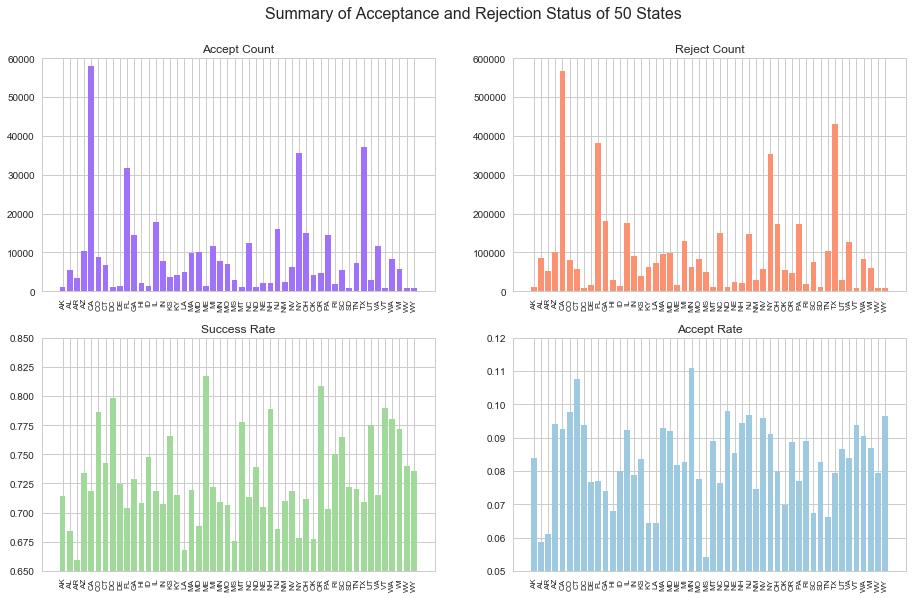

In [51]:
def add_subplot(factor, subplot,ylim, color):
    plt.subplot(subplot)
    plt.title(factor)
    #state_rate[factor].plot.bar(x='State', y=factor)
    plt.bar(x = state_rate['State'], height = state_rate[factor], color=color)
    plt.ylim(ylim)
    plt.xticks(rotation=90, fontsize=8)
fig, ax = plt.subplots(figsize=(12, 8))
fig.suptitle('Summary of Acceptance and Rejection Status of 50 States', fontsize=16)
add_subplot('Accept Count', 221,[0,60000], "#a072fc")
add_subplot('Reject Count', 222, [0,600000], "#fc9272")
add_subplot('Success Rate', 223, [0.65,0.85], '#a1d99b')
add_subplot('Accept Rate', 224, [0.05,0.12], '#9ecae1')

plt.subplots_adjust(top=0.89, bottom=0, left=0, right=1.0)

The accepted loan count and rejected loan count are similar for each state. However, the accepting rate and success return loan rate seems have non-constant relationship.

### Bias Analysis with Linear Regression

In [13]:
# Fit linear regression model to check relationship between success_rate and accept_rate
X = state_rate['Success Rate'].to_frame()
y = state_rate['Accept Rate']
succ_to_accept = LinearRegression().fit(X.values, y.values)

X_rf = state_rate['Success Rate'].to_frame()
y_rf = state_rate['RF Accept Rate']
succ_to_accept_rf = LinearRegression().fit(X_rf.values, y_rf.values)

X_nn = state_rate['Success Rate'].to_frame()
y_nn = state_rate['NN Accept Rate']
succ_to_accept_nn = LinearRegression().fit(X_rf.values, y_rf.values)

X_roi_rf = state_rate['Success Rate'].to_frame()
y_roi_rf = state_rate['ROI RF Accept Rate']
succ_to_accept_roi_rf = LinearRegression().fit(X_roi_rf.values, y_roi_rf.values)

X_roi_nn = state_rate['Success Rate'].to_frame()
y_roi_nn = state_rate['ROI NN Accept Rate']
succ_to_accept_roi_nn = LinearRegression().fit(X_roi_rf.values, y_roi_rf.values)

X_iroi_rf = state_rate['Success Rate'].to_frame()
y_iroi_rf = state_rate['IROI RF Accept Rate']
succ_to_accept_iroi_rf = LinearRegression().fit(X_iroi_rf.values, y_iroi_rf.values)

X_iroi_nn = state_rate['Success Rate'].to_frame()
y_iroi_nn = state_rate['IROI NN Accept Rate']
succ_to_accept_iroi_nn = LinearRegression().fit(X_iroi_rf.values, y_iroi_rf.values)

# r2 score
r2 = r2_score(y, succ_to_accept.predict(X.values))
rf_r2 = r2_score(y_rf, succ_to_accept_rf.predict(X_rf.values))
nn_r2 = r2_score(y_nn, succ_to_accept_nn.predict(X_nn.values))
roi_rf_r2 = r2_score(y_roi_rf, succ_to_accept_roi_rf.predict(X_roi_rf.values))
roi_nn_r2 = r2_score(y_roi_nn, succ_to_accept_roi_nn.predict(X_roi_nn.values))
iroi_rf_r2 = r2_score(y_iroi_rf, succ_to_accept_iroi_rf.predict(X_iroi_rf.values))
iroi_nn_r2 = r2_score(y_iroi_nn, succ_to_accept_iroi_nn.predict(X_iroi_nn.values))

# Consider the distance between estimated accept rate and true rate as bias
state_rate['BIAS'] = pd.Series(succ_to_accept.predict(X.values)) - y
state_rate.head()

,State,Success Rate,Accept Count,Reject Count,RF Accept Counts,NN Accept Counts,ROI RF Accept Counts,ROI NN Accept Counts,IROI RF Accept Counts,IROI NN Accept Counts,Total Loan,Accept Rate,RF Accept Rate,NN Accept Rate,ROI RF Accept Rate,ROI NN Accept Rate,IROI RF Accept Rate,IROI NN Accept Rate,BIAS
0,AK,0.714597,1006,10984,131,115,20,32,131,109,11990,0.083903,0.010926,0.009591,0.001668,0.002669,0.010926,0.009091,-0.002699
1,AL,0.683806,5329,85421,681,609,62,102,677,556,90750,0.058722,0.007504,0.006711,0.000683,0.001124,0.007460,0.006127,0.018300
2,AR,0.659658,3335,51294,392,370,41,53,439,324,54629,0.061048,0.007176,0.006773,0.000751,0.000970,0.008036,0.005931,0.012694
3,AZ,0.733703,10462,100749,1654,1592,223,315,1773,1440,111211,0.094073,0.014873,0.014315,0.002005,0.002832,0.015943,0.012948,-0.010273
4,CA,0.718838,57888,567707,8368,7773,1084,1635,8914,7198,625595,0.092533,0.013376,0.012425,0.001733,0.002614,0.014249,0.011506,-0.010752


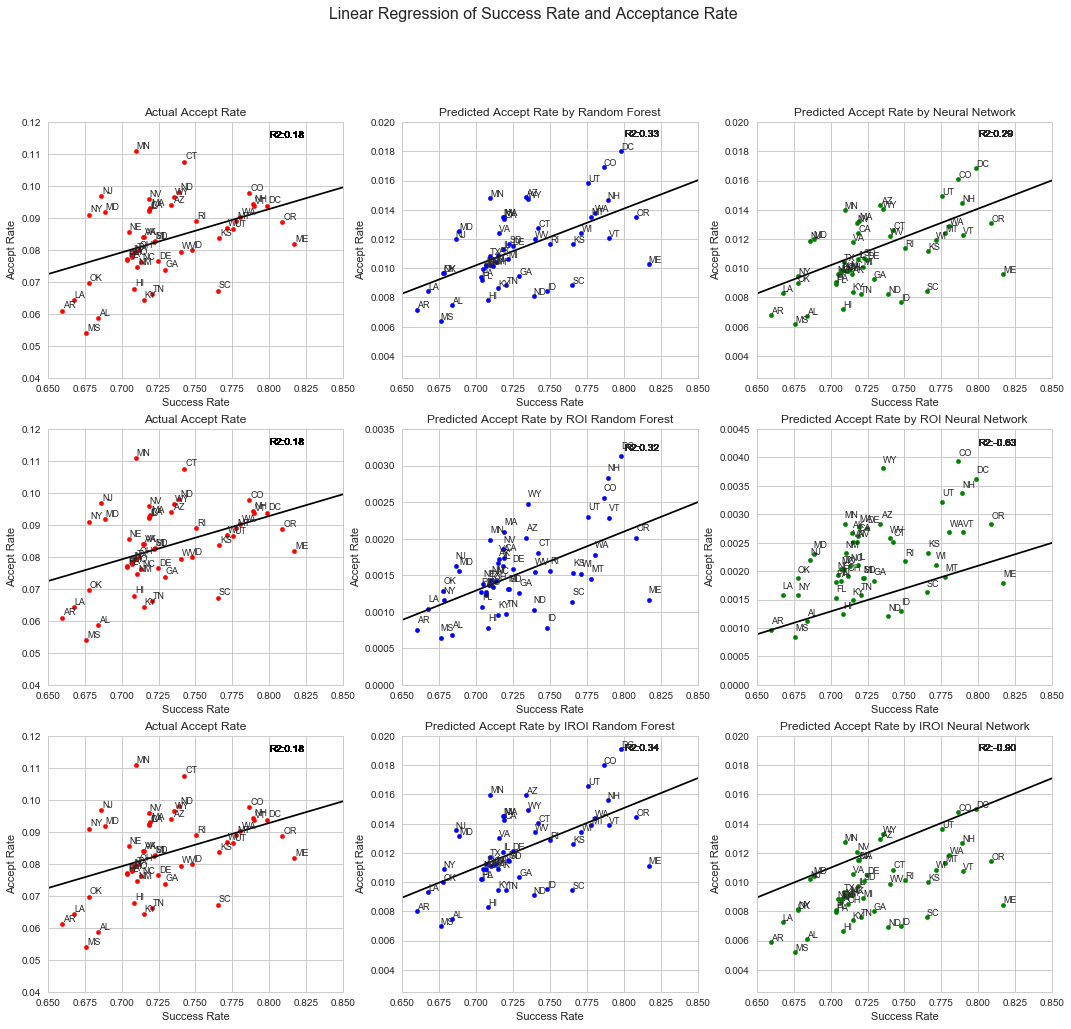

In [34]:
from scipy.stats import pearsonr

values = pd.Series(np.arange(0, 8, 0.01)).to_frame()

prediction = succ_to_accept.predict(values.values)
prediction_rf = succ_to_accept_rf.predict(values.values)
prediction_nn = succ_to_accept_nn.predict(values.values)
prediction_roi_rf = succ_to_accept_roi_rf.predict(values.values)
prediction_roi_nn = succ_to_accept_roi_nn.predict(values.values)
prediction_iroi_rf = succ_to_accept_iroi_rf.predict(values.values)
prediction_iroi_nn = succ_to_accept_iroi_nn.predict(values.values)
trend_line = pd.DataFrame({'Success Rate': values[0], 'Accept Rate': prediction})
trend_line_rf = pd.DataFrame({'Success Rate': values[0], 'RF Accept Rate': prediction_rf})
trend_line_nn = pd.DataFrame({'Success Rate': values[0], 'NN Accept Rate': prediction_nn})
trend_line_roi_rf = pd.DataFrame({'Success Rate': values[0], 'RF Accept Rate': prediction_roi_rf})
trend_line_roi_nn = pd.DataFrame({'Success Rate': values[0], 'NN Accept Rate': prediction_roi_nn})
trend_line_iroi_rf = pd.DataFrame({'Success Rate': values[0], 'RF Accept Rate': prediction_iroi_rf})
trend_line_iroi_nn = pd.DataFrame({'Success Rate': values[0], 'NN Accept Rate': prediction_iroi_nn})

fig, ax = plt.subplots(figsize=(18, 16))
fig.suptitle('Linear Regression of Success Rate and Acceptance Rate',fontsize=16)

plt.subplot(331)
for i in range(len(state_rate)):
    x = state_rate['Success Rate'][i]
    y = state_rate['Accept Rate'][i]
    plt.scatter(x, y, s=20, color='r')
    plt.text(x+0.0008, y+0.0008, state_rate['State'][i], fontsize=9)
    plt.text(0.80,0.115,'R2:{0:.2f}'.format(r2),color='k')
plt.plot(trend_line['Success Rate'], trend_line['Accept Rate'], color='k')
plt.xlim([0.65, 0.85])
plt.ylim([0.04, 0.12])
plt.title('Actual Accept Rate')
plt.xlabel('Success Rate')
plt.ylabel('Accept Rate')

plt.subplot(332)
for i in range(len(state_rate)):
    x = state_rate['Success Rate'][i]
    y = state_rate['RF Accept Rate'][i]
    plt.scatter(x, y, s=20, color='b')
    plt.text(x+0.0001, y+0.0001, state_rate['State'][i], fontsize=9)
    plt.text(0.80,0.019,'R2:{0:.2f}'.format(rf_r2))
plt.plot(trend_line['Success Rate'], trend_line_rf['RF Accept Rate'], color='k')
plt.xlim([0.65, 0.85])
plt.ylim([0.0025, 0.02])
plt.title('Predicted Accept Rate by Random Forest')
plt.xlabel('Success Rate')
plt.ylabel('Accept Rate')

plt.subplot(333)
for i in range(len(state_rate)):
    x = state_rate['Success Rate'][i]
    y = state_rate['NN Accept Rate'][i]
    plt.scatter(x, y, s=20, color='g')
    plt.text(x+0.0001, y+0.0001, state_rate['State'][i], fontsize=9)
    plt.text(0.80,0.019,'R2:{0:.2f}'.format(nn_r2))
plt.plot(trend_line['Success Rate'], trend_line_nn['NN Accept Rate'], color='k')
plt.xlim([0.65, 0.85])
plt.ylim([0.0025, 0.02])
plt.title('Predicted Accept Rate by Neural Network')
plt.xlabel('Success Rate')
plt.ylabel('Accept Rate')

plt.subplot(334)
for i in range(len(state_rate)):
    x = state_rate['Success Rate'][i]
    y = state_rate['Accept Rate'][i]
    plt.scatter(x, y, s=20, color='r')
    plt.text(x+0.0008, y+0.0008, state_rate['State'][i], fontsize=9)
    plt.text(0.80,0.115,'R2:{0:.2f}'.format(r2),color='k')
plt.plot(trend_line['Success Rate'], trend_line['Accept Rate'], color='k')
plt.xlim([0.65, 0.85])
plt.ylim([0.04, 0.12])
plt.title('Actual Accept Rate')
plt.xlabel('Success Rate')
plt.ylabel('Accept Rate')

plt.subplot(335)
for i in range(len(state_rate)):
    x = state_rate['Success Rate'][i]
    y = state_rate['ROI RF Accept Rate'][i]
    plt.scatter(x, y, s=20, color='b')
    plt.text(x+0.0001, y+0.0001, state_rate['State'][i], fontsize=9)
    plt.text(0.80,0.0032,'R2:{0:.2f}'.format(roi_rf_r2))
plt.plot(trend_line['Success Rate'], trend_line_roi_rf['RF Accept Rate'], color='k')
plt.xlim([0.65, 0.85])
plt.ylim([0.0, 0.0035])
plt.title('Predicted Accept Rate by ROI Random Forest')
plt.xlabel('Success Rate')
plt.ylabel('Accept Rate')

plt.subplot(336)
for i in range(len(state_rate)):
    x = state_rate['Success Rate'][i]
    y = state_rate['ROI NN Accept Rate'][i]
    plt.scatter(x, y, s=20, color='g')
    plt.text(x+0.0001, y+0.0001, state_rate['State'][i], fontsize=9)
    plt.text(0.80,0.0042,'R2:{0:.2f}'.format(roi_nn_r2))
plt.plot(trend_line['Success Rate'], trend_line_roi_nn['NN Accept Rate'], color='k')
plt.xlim([0.65, 0.85])
plt.ylim([0.0, 0.0045])
plt.title('Predicted Accept Rate by ROI Neural Network')
plt.xlabel('Success Rate')
plt.ylabel('Accept Rate')

plt.subplot(337)
for i in range(len(state_rate)):
    x = state_rate['Success Rate'][i]
    y = state_rate['Accept Rate'][i]
    plt.scatter(x, y, s=20, color='r')
    plt.text(x+0.0008, y+0.0008, state_rate['State'][i], fontsize=9)
    plt.text(0.80,0.115,'R2:{0:.2f}'.format(r2),color='k')
plt.plot(trend_line['Success Rate'], trend_line['Accept Rate'], color='k')
plt.xlim([0.65, 0.85])
plt.ylim([0.04, 0.12])
plt.title('Actual Accept Rate')
plt.xlabel('Success Rate')
plt.ylabel('Accept Rate')

plt.subplot(338)
for i in range(len(state_rate)):
    x = state_rate['Success Rate'][i]
    y = state_rate['IROI RF Accept Rate'][i]
    plt.scatter(x, y, s=20, color='b')
    plt.text(x+0.0001, y+0.0001, state_rate['State'][i], fontsize=9)
    plt.text(0.80,0.019,'R2:{0:.2f}'.format(iroi_rf_r2))
plt.plot(trend_line['Success Rate'], trend_line_iroi_rf['RF Accept Rate'], color='k')
plt.xlim([0.65, 0.85])
plt.ylim([0.0025, 0.02])
plt.title('Predicted Accept Rate by IROI Random Forest')
plt.xlabel('Success Rate')
plt.ylabel('Accept Rate')

plt.subplot(339)
for i in range(len(state_rate)):
    x = state_rate['Success Rate'][i]
    y = state_rate['IROI NN Accept Rate'][i]
    plt.scatter(x, y, s=20, color='g')
    plt.text(x+0.0001, y+0.0001, state_rate['State'][i], fontsize=9)
    plt.text(0.80,0.019,'R2:{0:.2f}'.format(iroi_nn_r2))
plt.plot(trend_line['Success Rate'], trend_line_iroi_nn['NN Accept Rate'], color='k')
plt.xlim([0.65, 0.85])
plt.ylim([0.0025, 0.02])
plt.title('Predicted Accept Rate by IROI Neural Network')
plt.xlabel('Success Rate')
plt.ylabel('Accept Rate')

x_ticks = ax.get_xticks()
y_ticks = ax.get_yticks()
ax.set_xticklabels(['{:3.2f}%'.format(k*100) for k in x_ticks])
ax.set_yticklabels(['{:3.2f}%'.format(k*100) for k in y_ticks])
ax.set_ylabel('Accept Rate (%)')
ax.set_xlabel('Success Rate (%)')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(13)
plt.show()

For the first plot, under non-discrimination assumption, we hope the successful return loan rate and accepting rate have positive linear relationship that successful return loan rate is the only cause of accepting rate. However, in reality, some states are off the line indicating there might be potential discrimination. For example, some states, such as OR and ME, have relative high return loan rate compare to CO and DC, but they also have smaller accepting rate. On the other hand, some states, like NY and NJ, have relative small successful return loan rate but have accepting rate.     
The second and third plots represent the relationship between predicted accept rate by our random forest and neural network models and the actual success rate. We can see that the dots are more centered towards the trend line, indicating that the accept rate depend more on the successfully paid rate. Also, the $R^2$ of these two linear models are higher than the original model, which suggests that using the acceptance rate predicted by our models, the linear regression model can explain more variability of the response data. Therefore, we can conclude that if adopting the investment strategy based on our random forest or neural network models, there would be less potential demographical discrimination.

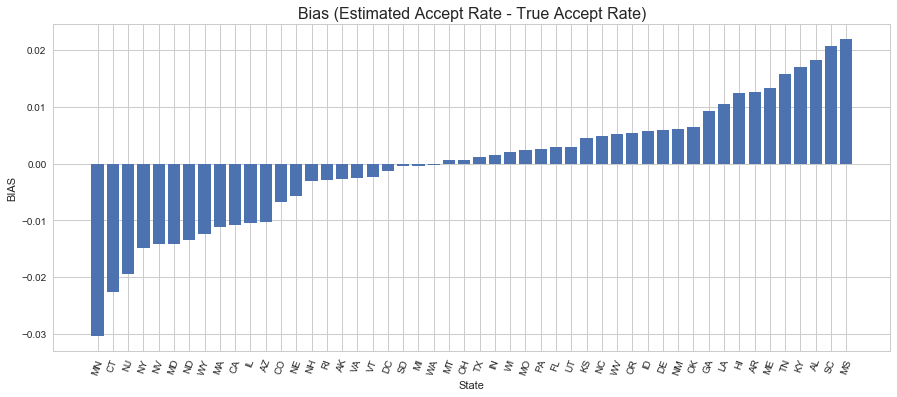

In [37]:
state_rate = state_rate.sort_values(by = 'BIAS')
fig, ax = plt.subplots(figsize=(15, 6))
plt.bar(x = state_rate['State'], height = state_rate['BIAS'])
plt.xticks(rotation=70)
y_ticks = ax.get_yticks()
ax.set_ylabel('BIAS')
ax.set_xlabel('State')
ax.set_title('Bias (Estimated Accept Rate - True Accept Rate)', fontsize=16)
plt.show()

Similar to previous plot, in reality, some states have high accepting rate than expected.

In [121]:
scl=[[0.0, 'rgb(165,0,38)'], [0.2, 'rgb(244,109,67)'], [0.4, 'rgb(254,224,144)'], 
            [0.6, 'rgb(171,217,233)'], [0.8, 'rgb(69,117,180)'], [1.0, 'rgb(49,54,149)']]
data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = state_rate['State'],
        z = state_rate['BIAS'].astype(float),
        locationmode = 'USA-states',
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "Bias")
        ) ]

layout = dict(
        title = 'Difference Between Actual and Estimated Accept Rate Based on Linear Regression',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
py.iplot( fig, filename='lendingclub-cloropleth-map-2' )

From the above US map, most northern states have lower rejection rates while southern states have higher rejection rates. This trend may show some discrimination in Lending Club.

### Difference Between Actual and Expect Number of Rejects

In [116]:
# The proportion of number of total loans for each state
p_all = df['State'].value_counts()/len(df)
p_all_df = pd.DataFrame({'State': p_all.index, 'All_Prop': p_all.values})
# The proportion of number of rejected loans for every state
p_rej = rej['State'].value_counts()/len(rej)
p_rej_df = pd.DataFrame({'State': p_rej.index, 'Rej_Prop': p_rej.values})
# The proportion of number of accepted loans for every state
p_acp = acp['State'].value_counts()/len(acp)
p_acp_df = pd.DataFrame({'State': p_acp.index, 'Acc_Prop': p_acp.values})

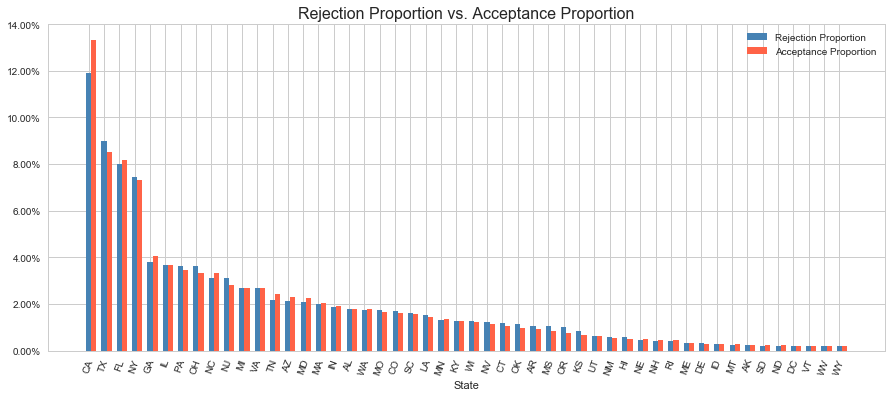

In [118]:
count_indices = np.arange(len(p_rej_df['State']))
width = np.min(np.diff(count_indices))/3.
names = p_rej_df['State']
fig, ax = plt.subplots(figsize=(15, 6))
ax.bar(count_indices-width/2.,p_rej_df['Rej_Prop'],width,color='Steelblue',
       tick_label = p_rej_df['State'],label='Rejection Proportion')
ax.bar(count_indices+width/2.,p_acp_df['Acc_Prop'],width,color='tomato',label='Acceptance Proportion')
#ax.axes.set_xticklabels(names)
ax.set_xticklabels(names, rotation=70)
ax.set_xlabel('State')
y_ticks = ax.get_yticks()
ax.set_yticklabels(['{:3.2f}%'.format(k*100) for k in y_ticks])
ax.legend()
ax.set_title('Rejection Proportion vs. Acceptance Proportion', fontsize=16)
plt.show()

Some states (CA, FL, AZ, etc) have higher acceptance proportion than rejection proportion.

In [119]:
state_prop = pd.merge(p_all_df, p_rej_df, how='left', on=['State'])
state_prop['Diff_Prop'] = state_prop['Rej_Prop'] - state_prop['All_Prop']
state_prop['Diff_num'] = state_prop['Diff_Prop']*len(rej)

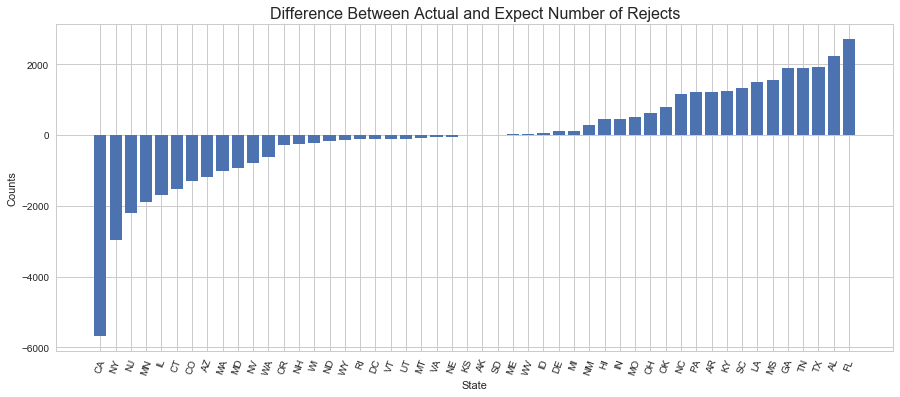

In [120]:
state_prop = state_prop.sort_values(by = 'Diff_num')
fig, ax = plt.subplots(figsize=(15, 6))
plt.bar(x = state_prop['State'], height = state_prop['Diff_num'])
plt.xticks(rotation=70)
y_ticks = ax.get_yticks()
ax.set_ylabel('Counts')
ax.set_xlabel('State')
ax.set_title('Difference Between Actual and Expect Number of Rejects', fontsize=16)
plt.show()

In reality, some states have lower rejected-loan counts than expected (states on the left) while many other states have higher rejected-loan counts than expected (states on the right).

In [254]:
import plotly.plotly as py

#ploty.tools.set_credentials_file(username='jingyichen', api_key='ithtgZkbeInxasauGeMe')

scl=[[0.0, 'rgb(165,0,38)'], [0.2, 'rgb(244,109,67)'], [0.4, 'rgb(254,224,144)'], 
            [0.6, 'rgb(171,217,233)'], [0.8, 'rgb(69,117,180)'], [1.0, 'rgb(49,54,149)']]
data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = state_prop['State'],
        z = state_prop['Diff_num'].astype(float),
        locationmode = 'USA-states',
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "Bias(counts)")
        ) ]

layout = dict(
        title = 'Difference Between Actual and Expected Number of Rejects',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
py.iplot( fig, filename='lendingclub-cloropleth-map' )

This graph shows that applications from areas with darker blue are more likely to be rejected, while applications from areas with darker red are less likely to be accepted, comparing with our estimated rejection number. The dark blue areas are mostly southern states (Florida, Texas, Alabama, Tennessee, etc), and the red areas include California, New York, Massachusetts, and etc. This indicates a general pattern that applicants from states which have worse economic status (e.g. lower median household incomes) are more likely to be rejected than expected, and applicants from states which have better economic status face lower probability of rejection than expected. 